# Cookie Cats
<p>Мобильная игра Cookie Cats разбита на отдельные уровни, между которыми, в некоторый момент, добавляются ворота (калитки),
блокирующие доступ к остальным уровням. Для прохода через калитку требуется собрать недостающие ключи или совершить внутриигровую покупку.</p>
<p>В данном датасете приведены данные пользователей, разделенных на две группы. В первой группе калитка была установлена на 30 уровне, во второй группе - на 40 уровне.</p>
<p>В ходе анализа полученных данных необходимо установить наличие или отсутствие статистической значимости отличий между двумя группами по нескольким показателям.</p>

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

In [4]:
np.random.seed(0)

In [5]:
data = pd.read_csv('cookie_cats.csv')

# Структура датасета
<ul>
    <li><code>userid</code> - уникальный идентификатор пользователя;</li>
    <li><code>version</code> - группа пользователя (gate_30 или gate_40);</li>
    <li><code>sum_gamerounds</code> - количество сыгранных пользователем раундов за 14 дней с момента установки;</li>
    <li><code>retention_1</code> - retention первого дня;</li>
    <li><code>retention_7</code> - retention седьмого дня.</li>
</ul>

In [6]:
data.head(5)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [8]:
data.isnull().any()

userid            False
version           False
sum_gamerounds    False
retention_1       False
retention_7       False
dtype: bool

<p>В данных отсутствуют пропуски</p>

In [12]:
data.version.unique()

array(['gate_30', 'gate_40'], dtype=object)

In [10]:
data.groupby('version').count()

,userid,sum_gamerounds,retention_1,retention_7
version,,,,
gate_30,44700,44700,44700,44700
gate_40,45489,45489,45489,45489


<p>Количество измерений в каждой из двух групп примерно совпадает</p>

In [15]:
group_gate_30 = data[data.version == 'gate_30']
group_gate_40 = data[data.version == 'gate_40']

# Первая гипотеза
## Перенос калитки с 30 на 40 уровень не влияет на количество сыгранных раундов

In [16]:
print(f'Среднее выборочное группы gate_30: {np.mean(group_gate_30.sum_gamerounds)}')
print(f'Среднее выборочное группы gate_40: {np.mean(group_gate_40.sum_gamerounds)}')

Среднее выборочное группы gate_30: 52.45626398210291
Среднее выборочное группы gate_40: 51.29877552814966


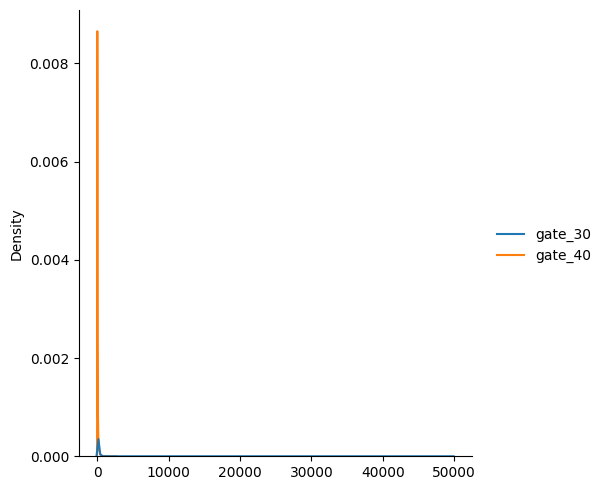

In [17]:
sns.displot({
    'gate_30': group_gate_30.sum_gamerounds,
    'gate_40': group_gate_40.sum_gamerounds
},
kind='kde')

### Вид распределений обоих групп вызывает вопрос о наличии выбросов, проведем логарифмирование

In [18]:
group_gate_30.sum_gamerounds = np.log(group_gate_30.sum_gamerounds + 1)
group_gate_40.sum_gamerounds = np.log(group_gate_40.sum_gamerounds + 1)

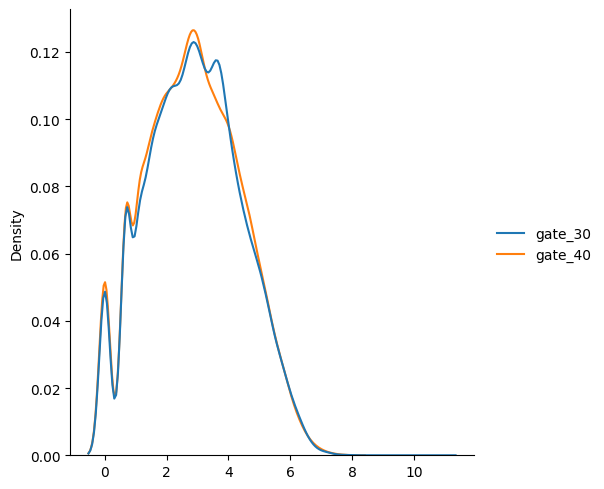

In [14]:
sns.displot({
    'gate_30': group_gate_30.sum_gamerounds,
    'gate_40': group_gate_40.sum_gamerounds
},
kind='kde')

### После логарифимирования графики распределений визуально слабо отличаются

In [19]:
pvalue = ttest_ind(group_gate_30.sum_gamerounds, group_gate_40.sum_gamerounds).pvalue

print(pvalue)

0.06966089932684477


### P-value теста Стьюдента ~0.0697, что больше стандартного критического значения 0.05

# Вторая гипотеза
## Перенос калитки с 30 на 40 уровень не влияет на возвращение пользователей в 1 день

In [27]:
chi_matrix = pd.DataFrame([pd.Series([len(group_gate_30[group_gate_30.retention_1 == 1]),
                                      len(group_gate_30[group_gate_30.retention_1 == 0])]),
                           pd.Series([len(group_gate_40[group_gate_40.retention_1 == 1]),
                                      len(group_gate_40[group_gate_40.retention_1 == 0])])
                          ])

chi_matrix.index = ['gate_30', 'gate_40']
chi_matrix.columns = ['Вернулся на следующий день', 'НЕ вернулся на следующий день']

chi_matrix

,Вернулся на следующий день,НЕ вернулся на следующий день
gate_30,20034,24666
gate_40,20119,25370


In [30]:
a = int(chi_matrix.loc['gate_30', 'Вернулся на следующий день'])
b = int(chi_matrix.loc['gate_30', 'НЕ вернулся на следующий день'])
c = int(chi_matrix.loc['gate_40', 'Вернулся на следующий день'])
d = int(chi_matrix.loc['gate_40', 'НЕ вернулся на следующий день'])

chi_squared = (a*d - b*c)**2 * sum([a, b, c, d]) / ((a + b)*(c + d)*(a + c)*(b + d))

print(chi_squared)
print('Критическое значение: 3.841')

3.182963657512103
Критическое значение: 3.841


### Значение хи-квадрат (3.183) меньше критического значения (3.841) для таблицы 2x2 (1 степень свободы)

# Третья гипотеза
## Перенос калитки с 30 на 40 уровень не влияет на возвращение пользователя в 7 день

In [33]:
chi_matrix = pd.DataFrame([pd.Series([len(group_gate_30[group_gate_30.retention_7 == 1]),
                                      len(group_gate_30[group_gate_30.retention_7 == 0])]),
                           pd.Series([len(group_gate_40[group_gate_40.retention_7 == 1]),
                                      len(group_gate_40[group_gate_40.retention_7 == 0])])
                          ])

chi_matrix.index = ['gate_30', 'gate_40']
chi_matrix.columns = ['Вернулся на 7 день', 'НЕ вернулся на 7 день']

chi_matrix

,Вернулся на 7 день,НЕ вернулся на 7 день
gate_30,8502,36198
gate_40,8279,37210


In [34]:
a = int(chi_matrix.loc['gate_30', 'Вернулся на 7 день'])
b = int(chi_matrix.loc['gate_30', 'НЕ вернулся на 7 день'])
c = int(chi_matrix.loc['gate_40', 'Вернулся на 7 день'])
d = int(chi_matrix.loc['gate_40', 'НЕ вернулся на 7 день'])


chi_squared = (a*d - b*c)**2 * sum([a, b, c, d]) / ((a + b)*(c + d)*(a + c)*(b + d))

print(chi_squared)
print('Критическое значение: 3.841')

10.013167328688963
Критическое значение: 3.841


### Значение хи-квадрат (10.013) больше критического значения (3.841) для таблицы 2x2 (1 степень свободы)

# Дополнительная проверка второй и третьей гипотез с помощью bootstrap

In [35]:
def get_percentile_ci(bootstrap_stats, alpha):
    """
    Функция расчета границ перцентильного доверительного интервала.
    
    Параметры: bootstrap_stats - список замеров параметра, для которого строится доверительный интервал;
               alpha - уровень значимости.
               
    Возвращаемые значения: a - левая граница интервала;
                           b - правая граница интервала.
    """
    
    a, b = np.quantile(bootstrap_stats, [alpha / 2, 1 - alpha / 2])
    
    return a, b

In [37]:
def bootstrap(group_a, group_b):
    """
    Функция расчета разницы между средними значениями количества вернувшихся пользователей.
    
    Параметры: group_a - первая группа;
               group_b - вторая группа.
    
    Возвращаемые значения: bootstrap_difference - список разниц между средними;
                           bootstrap_group_a - список средних для первой группы;
                           bootstrap_group_b - список средних для второй группы.
    """
    
    bootstrap_difference = list()
    bootstrap_group_a_mean = list()
    bootstrap_group_b_mean = list()

    for _ in range(1000):

        bootstrap_group_a = list()
        bootstrap_group_b = list()

        for _ in range(100):
            sample = np.random.choice(group_a, 1000, True)
            bootstrap_group_a.append(len(sample[sample == 1]))

        for _ in range(100):
            sample = np.random.choice(group_b, 1000, True)
            bootstrap_group_b.append(len(sample[sample == 1]))

        bootstrap_group_a_mean.append(np.mean(bootstrap_group_a))
        bootstrap_group_b_mean.append(np.mean(bootstrap_group_b))

        bootstrap_difference.append(bootstrap_group_a_mean[-1] - bootstrap_group_b_mean[-1])
    
    return bootstrap_difference, bootstrap_group_a_mean, bootstrap_group_b_mean

In [39]:
bootstrap_retention_1, bootstrap_gate_30_retention_1, bootstrap_gate_40_retention_1 = bootstrap(group_gate_30.retention_1,
                                                                                               group_gate_40.retention_1)

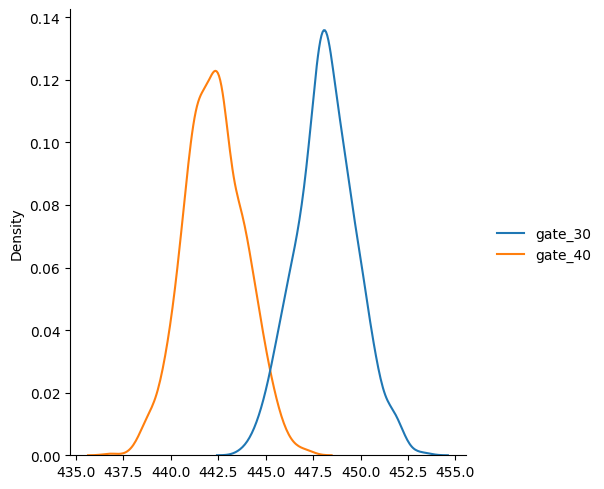

In [40]:
sns.displot({
    'gate_30': bootstrap_gate_30_retention_1,
    'gate_40': bootstrap_gate_40_retention_1
},
kind='kde')

In [42]:
a, b = get_percentile_ci(bootstrap_retention_1, 0.05)

print(a, b)

1.3279999999999845 10.070999999999993


### 0 не попадает в доверительный интервал [1.328, 10.071]

In [43]:
bootstrap_retention_7, bootstrap_gate_30_retention_7, bootstrap_gate_40_retention_7 = bootstrap(group_gate_30.retention_7,
                                                                                               group_gate_40.retention_7)

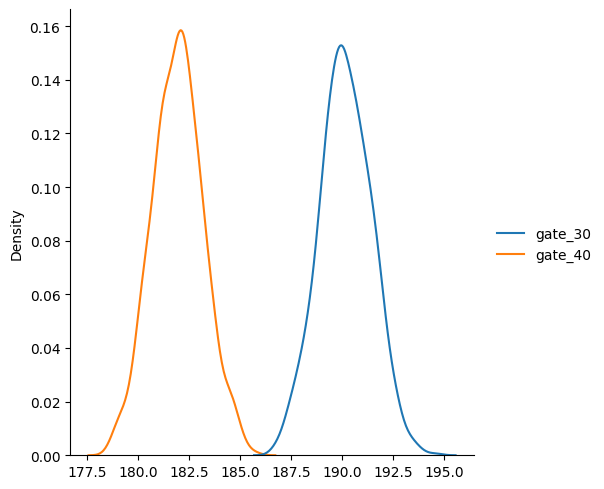

In [44]:
sns.displot({
    'gate_30': bootstrap_gate_30_retention_7,
    'gate_40': bootstrap_gate_40_retention_7
},
kind='kde')

In [45]:
a, b = get_percentile_ci(bootstrap_retention_7, 0.05)

print(a, b)

4.879749999999996 11.650250000000005


### 0  не попадает в доверительный интервал [4.879, 11.650]

# Вывод
<p>По результата T-теста Стьюдента <strong>нельзя</strong> опровергнуть нулевую гипотезу (уровень значимости - 0.05) об отсутствии влияния сдвига калитки с 30 на 40 уровень на количество сыгранных пользователем раундов.</p>
<p>По результатам теста Хи-квадрат Пирсона <strong>нельзя</strong> опровергнуть нулевую гипотезу (уровень значимости - 0.05) об отсутствии влияния сдвига калитки с 30 на 40 уровень на retention первого дня, при этом, по результатам bootstrap (0 не попадает в доверительный интервал), <strong>можно</strong> говорить о статистической разнице между группами по этому показателю.</p>
<p><p>По результатам теста Хи-квадрат Пирсона <strong>можно</strong> опровергнуть нулевую гипотезу (уровень значимости - 0.05) об отсутствии влияния сдвига калитки с 30 на 40 уровень на retention седьмого дня. Это также подтверждается по результатам bootstrap (0 не попадает в доверительный интервал).</p>

<p><i>Сдвиг калитки с 30 на 40 уровень оказывает негативное влияние на показатели возвращения пользователя в 1 и 7 день и не влияет на количество сыгранных раундов.</i></p>